# 데이터 불러오기

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/aiffel_exp5_audio/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  18398
Wave data shape :  (8000,)
label :  ['up']


# 라벨 데이터 처리

In [3]:
# 학습에 사용하기 위해 text로 이루어진 라벨 데이터 index형태로 변환
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


# int로 이뤄진 index작업을 통해 label data를 더 쉽게 사용 가능

In [4]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

# 학습을 위한 데이터 분리

In [5]:
# skelarn의 train_test_split 함수를 통해 train_data와 test_data분리  
# test_size 인자를 조절해주면 설정해준 값 만큼 test dataset 비율 조정 가능
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[-1.3480627e-03 -3.0887211e-03 -3.7198574e-03 ... -3.6327117e-03
  -2.8507612e-03 -3.5303112e-03]
 [-3.6799433e-05 -1.3772954e-04 -2.1407851e-04 ...  2.7127398e-04
   2.3606526e-04  2.3714842e-04]
 [ 3.2021098e-03  4.5678220e-03 -3.3242512e-05 ...  2.1530204e-03
   1.7275357e-03 -2.1728419e-03]
 ...
 [-9.9568290e-04 -4.8882631e-04  8.5403101e-04 ... -1.1043933e-02
  -1.0444577e-02 -1.1114695e-02]
 [-5.7979491e-05 -1.2326159e-04 -1.9964203e-04 ... -6.8713598e-05
  -5.4574710e-05 -6.6065120e-05]
 [ 9.1296051e-06  1.0309958e-05 -3.8449930e-06 ...  3.9935881e-06
   3.0000174e-05 -2.4220519e-05]]
✅


# 나눠진 데이터셋 확인

In [6]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


# 하이퍼파라미터 설정

In [7]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/aiffel_exp5_audio/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj47/aiffel/aiffel_exp5_audio/speech_recognition/models/wav'

# map함수에 넘겨줄 데이터 전처리 함수 작성

In [8]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


# tf.data.Dataset 함수 구성
# batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수

In [9]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


# 스펙토그램 생성

In [10]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [11]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


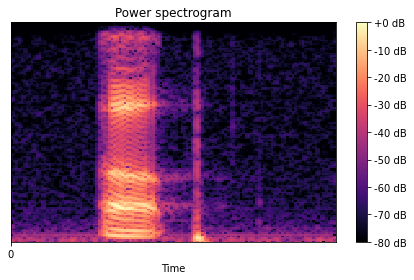

In [12]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

# 5-4. Wave classification 모델 구현

## Model
audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성해줘야 함  
Conv1D layer이용해서 모델 구성
Conv, batch norm, dropout, dense layer등을 이용해 모델 구성

In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [14]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [16]:
# 모델 학습코드
# 이전 스텝의 하이퍼파라미터 세팅에서 batch_size = 30, max_epochs=10으로 세팅한경우 30분 가량 소요
# 메모리 사용량에 주의하며 하이퍼파라미터 세팅 조절
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.4488 - accuracy: 0.5188
Epoch 00001: val_loss improved from inf to 1.01794, saving model to /home/aiffel-dj47/aiffel/aiffel_exp5_audio/speech_recognition/models/wav
1423/1423 [==============================] - 147s 103ms/step - loss: 1.4488 - accuracy: 0.5188 - val_loss: 1.0179 - val_accuracy: 0.6709
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.8581 - accuracy: 0.7328
Epoch 00002: val_loss improved from 1.01794 to 0.78379, saving model to /home/aiffel-dj47/aiffel/aiffel_exp5_audio/speech_recognition/models/wav
1423/1423 [==============================] - 150s 105ms/step - loss: 0.8581 - accuracy: 0.7328 - val_loss: 0.7838 - val_accuracy: 0.7494
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.8085
Epoch 00003: val_loss improved from 0.78379 to 0.53969, saving model to /home/aiffel-dj47/aiffel/aiffel_exp5_audio/speech_recognition/models/wav
1

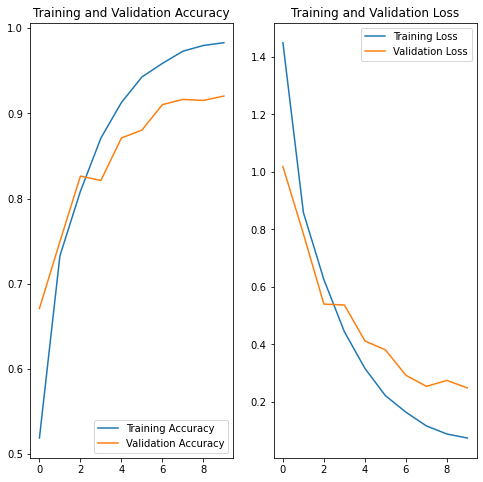

✅


In [17]:
# 출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

# evaluation

In [18]:
# test dataset을 이용해 모델의 성능 평가
# 실습삼아 checkpoint callback함수가 저장한 weight를 다시 불러와 테스트 준비
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [19]:
# test data를 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 11s 70ms/step - loss: 0.2481 - accuracy: 0.9204
✅


In [20]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.248
accuracy value: 92.0387%
✅


# model test

In [21]:
# test data셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  left


In [22]:
# 위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과 확인
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: left(Correct!)
✅


# 5-5. Skip-Connection model을 추가해보자 

In [23]:
# 1차원audio데이터 처리하는 모델 구성
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()
# 모델 구성만 달라졌을분 Task구성이나 데이터셋 구성, 훈련과정은 동일

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [24]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [25]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [26]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.2371 - accuracy: 0.6042
Epoch 00001: val_loss improved from inf to 0.77316, saving model to /home/aiffel-dj47/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 176s 123ms/step - loss: 1.2371 - accuracy: 0.6042 - val_loss: 0.7732 - val_accuracy: 0.7609
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.8109
Epoch 00002: val_loss improved from 0.77316 to 0.54875, saving model to /home/aiffel-dj47/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 181s 127ms/step - loss: 0.6391 - accuracy: 0.8109 - val_loss: 0.5487 - val_accuracy: 0.8341
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.9095
Epoch 00003: val_loss improved from 0.54875 to 0.37107, saving model to /home/aiffel-dj47/aiffel/speech_recognition/models/wav_skip
1423/1423 [=============================

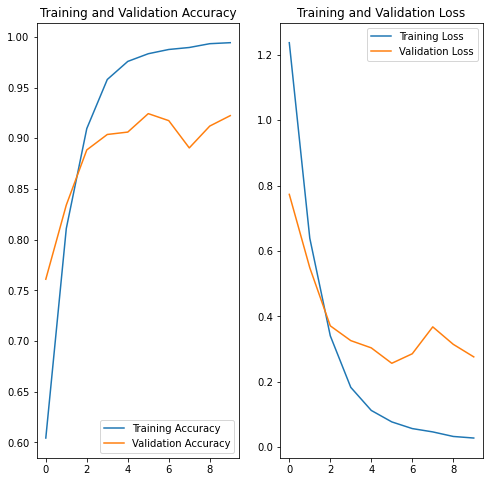

✅


In [27]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [28]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 8s 47ms/step - loss: 0.2562 - accuracy: 0.9243
loss value: 0.256
accuracy value: 92.4338%
✅


In [29]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  stop


In [30]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: stop(Correct!)
✅


# 총평

#### 1. 노드 소감 : ㅠ_ㅠ
**(먼저 제출하는 파일은 과제 제출용이기도 하지만 나중에 과정 다 끝나면 보려고 기록용으로도 쓰는 것이기 때문에 잡다한 내용이 있는 점 양해 부탁드립니다.)**

이번 자연어 exploration은 ... 어려웠다.  
지난 exp4 총평에 여태까지 복사, 붙여넣기만 했을 뿐인데 조금씩 감이 온다는 건 큰 착각이었다.  
이번에는 전혀 감을 잡을 수 없었다.
어떻게 풀어야 할지 몰랐다. 그냥 다 몰랐다.  
스펙토그램에 데이터를 어떻게 넣어야 하는지도 모르겠고...  
만약 어찌저찌 해서 넣었다고 한들... 그 다음에 또 막혔을거다.  
노드에 나오는 모델을 복붙해서 값이 나오긴 했는데 저게 맞는건지, 뭔지 잘 모르겠다.  
너무 어려운 노드였다.  
  
더 이상은 잘 모르겠어서 제출한다.

---

#### 1. 한 달 후기
지금 약 1개월 정도 아이펠 과정이 지났다.  
슬랙에 올라오는 글을 보면 조금씩 사람들이 코드를 보고 분석하면서 필요한 코드를 활용할 수 있는 것 같다.  
cs231n에서도 자신들이 이해한 내용으로 토론하는 걸 보면 다들 뭔가 나보다 훨씬 깊이있게 내용을 이해하는 것 같다. 사람들이 내용에 대해 토론하는 모습을 보면 무슨 sf영화 보듯이 그냥 신기하다 ㅋㅋㅋㅋㅋ 수학적인 내용이라도 조금 추가되면 나는 이해할 수 없는 미지의 세계에 대해서 얘기하는 것 같다.
  
과정 자체는 분명 재밌다.(cs231n 빼고)  
재미는 있지만 cs231n은 토론하고 발표할 정도로 이해가 안되고 노드도 복사, 붙여넣기만 한다는 것 빼고는.. 아직은? 잘 모르겠다.   
누군가 지금까지 뭘 배웠냐고 물어보면 지금은 "대충 알고있는(강의 보면 누구나 다 알 수 있는) cs231n내용 말해주고 코드는 복사, 붙여넣기만 해서 잘 모르겠어. 내가 뭘 할 수 있는 건 없어" 라고 말할 것 같다. (이 글을 다시 볼 때 쯤엔 저 말 보단 더 멋있게 말할 수 있길.....)   
지금까지는 내가 뭘 배웠을까, 이래서 이 다음 과정인 해커톤인가를 내가 할 수 있나 생각든다.  
  
뭐 배운게 없는 것 같고 잘 이해 못하고 뭐 어렵고 등등은 내가 부족한거니깐 둘째치고  
내가 이 과정에서 제일 중요하게 생각하는 부분은 "내가 재밌어 하냐"가 제일 중요한데 지금은 재밌다 ㅋㅋㅋㅋ 아무것도 모르는데 모르는데로 재밌다. 뭐가 재밌는지조차 모르겠는데 그냥 신기하고 재밌다. 뭔가 간단히라도 얘기하자면 아무것도 모르는 미지의 세계를 탐험하는 기분이랄까...?  
  
아무튼 재미가 제일 중요한데 복붙만 하다보니 약간 공장 같고 머릿속에 아무것도 안 남는 것 같아서 지금 진행하는 exp6부터 노드에 나오는 모든 코드를 직접 입력하고 있는데 직접 코드를 입력하는 것이 복사, 붙여넣기 보다는 훨씬 재밌다 ㅋㅋㅋㅋ 코드를 보면서 입력하다 보면 시간도 잘가고 아주 재밌다. 너무 긴 코드가 아닌 이상 앞으론 계속 입력할 생각이다.   
뭐 이렇게 한다고 더 나아질지는 모르겠지만 어차피 모르는 거는 이러나 저러나 똑같을테고 이렇게라도 해보는 게 복사, 붙여넣기보다는 남는 게 많지 않을까 생각한다.  
    
앞으로 더 어려운 내용도 나올테고 그만큼 모르는 게 더 많아지겠지만 항상 재밌게 하면 좋겠다~!
  
**혹시 퍼실님들이 보시기에 과정에 대해 불만이 있어 보일 수 있지만 그런건 절.대. 아닙니다. 이해 안되고 어려울 뿐이지 재밌게 하고 있습니다 ㅋㅋㅋ**